# Regression data using scikit-learn

Regression is when the feature to be predicted contains continuous values. Regression refers to the process of predicting a dependent variable by analyzing the relationship between other independent variables. There are several algorithms known to us that help us in excavating these relationships to better predict the value.

In this notebook, we'll use scikit-learn to predict values. Scikit-learn provides implementations of many regression algorithms. In here, we have done a comparative study of 5 different regression algorithms. 

To help visualize what we are doing, we'll use 2D and 3D charts to show how the classes looks (with 3 selected dimensions) with matplotlib and seaborn python libraries.


<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Helper methods for metrics](#helper_methods)
3. [Data exploration](#explore_data)
4. [Prepare data for building regression model](#prepare_data)
5. [Build Simple Linear Regression model](#model_slr)
6. [Build Multiple Linear Regression classification model](#model_mlr)
7. [Build Polynomial Linear Regression model](#model_plr) 
8. [Build Decision Tree Regression model](#model_dtr) 
9. [Build Random Forest Regression model](#model_rfr)
10. [Comparitive study of different regression algorithms](#compare_classification)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code such as the one below. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Install python modules
NOTE! Some pip installs require a kernel restart.
The shell command pip install is used to install Python modules. Some installs require a kernel restart to complete. To avoid confusing errors, run the following cell once and then use the Kernel menu to restart the kernel before proceeding.

In [1]:
!pip install pandas==0.24.2
!pip install --user pandas_ml==0.6.1
#downgrade matplotlib to bypass issue with confusion matrix being chopped out
!pip install matplotlib==3.1.0
!pip install seaborn
!pip install pydot
!pip install graphviz


     |████████████████████████████████| 10.1MB 7.6MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011
     |████████████████████████████████| 13.1MB 6.6MB/s eta 0:00:01
  Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score

import pandas as pd, numpy as np
import sys
import io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot



<a id="helper_methods"></a>
## 2. Helper methods for metrics
[Top](#top)



In [3]:

def two_d_compare(X_test,y_test,y_pred,model_name):
    area = (12 * np.random.rand(40))**2 
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Variance score: %.2f' % r2_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test, y_test, alpha=0.8, color='#8CCB9B')
    plt.title('Actual')

    plt.subplot(122)
    plt.scatter(X_test, y_pred,alpha=0.8, color='#E5E88B')
    plt.title('Predicted')

    plt.show()
    

def model_metrics(regressor,y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.2f"
      % mse)
    r2 = r2_score(y_test, y_pred)
    print('R2 score: %.2f' % r2 )
    return [mse, r2]

def two_vs_three(x_test,y_test,y_pred,z=None, isLinear = False) : 
    
    area = 60
    

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('2D and 3D view of sales price data')

    # First subplot
    ax = fig.add_subplot(1, 2,1)
    ax.scatter(x_test, y_test, alpha=0.5,color='blue', s= area)
    ax.plot(x_test, y_pred, alpha=0.9,color='red', linewidth=2)
    ax.set_xlabel('YEAR BUILT')
    ax.set_ylabel('SELLING PRICE')
    
    plt.title('YEARBUILT vs SALEPRICE')
    
    if not isLinear : 
    # Second subplot
        ax = fig.add_subplot(1,2,2, projection='3d')

        ax.scatter(z, x_test, y_test, color='blue', marker='o')
        ax.plot(z, x_test, y_pred, alpha=0.9,color='red', linewidth=2)
        ax.set_ylabel('YEAR BUILT')
        ax.set_zlabel('SELLING PRICE')
        ax.set_xlabel('LOT AREA')

    plt.title('LOT AREA vs YEAR BUILT vs SELLING PRICE')

    plt.show()
    

<a id="explore_data"></a>
## 3. Data exploration
[Top](#top)

Data can be easily loaded within IBM Watson Studio. Instructions to load data within IBM Watson Studio can be found [here](https://ibmdev1.rtp.raleigh.ibm.com/tutorials/watson-studio-using-jupyter-notebook/). The data set can be located by its name and inserted into the notebook as a pandas DataFrame as shown below.

![insert_spark_dataframe.png](https://raw.githubusercontent.com/IBM/icp4d-customer-churn-classifier/master/doc/source/images/insert_spark_dataframe.png)

The generated code comes up with a generic name and it is good practice to rename the dataframe to match the use case context.


In the snippet below, we use the pandas library to load a csv that contains housing related information. With several independent variables related to this domain, we are going to predict the sales price of a house. 

In [4]:
df_pd =  pd.read_csv("https://raw.githubusercontent.com/IBM/ml-learning-path-assets/master/data/predict_home_value.csv")
df_pd.head()

,ID,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
0,1,8450,1Fam,2Story,5,2003,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,2,2008,208500
1,2,9600,1Fam,1Story,8,1976,Gable,TA,CBlock,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,5,2007,181500
2,3,11250,1Fam,2Story,5,2001,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,9,2008,223500
3,4,9550,1Fam,2Story,5,1915,Gable,TA,BrkTil,Gd,...,Detchd,Unf,3,TA,0,NaN,NaN,2,2006,140000
4,5,14260,1Fam,2Story,5,2000,Gable,TA,PConc,TA,...,Attchd,RFn,3,TA,0,NaN,NaN,12,2008,250000


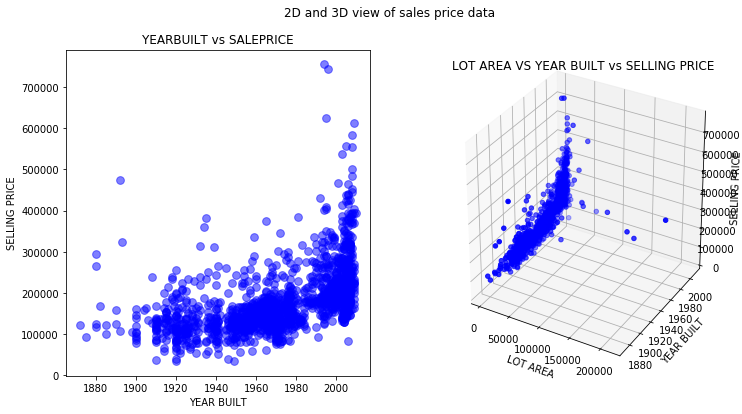

In [5]:
area = 60
x = df_pd['YEARBUILT']
y = df_pd['SALEPRICE']
z = df_pd['LOTAREA']


fig = plt.figure(figsize=(12,6))
fig.suptitle('2D and 3D view of sales price data')

# First subplot
ax = fig.add_subplot(1, 2,1)

ax.scatter(x, y, alpha=0.5,color='blue', s= area)
ax.set_xlabel('YEAR BUILT')
ax.set_ylabel('SELLING PRICE')

plt.title('YEARBUILT vs SALEPRICE')

# Second subplot
ax = fig.add_subplot(1,2,2, projection='3d')

ax.scatter(z, x, y, color='blue', marker='o')

ax.set_ylabel('YEAR BUILT')
ax.set_zlabel('SELLING PRICE')
ax.set_xlabel('LOT AREA')

plt.title('LOT AREA VS YEAR BUILT vs SELLING PRICE')

plt.show()


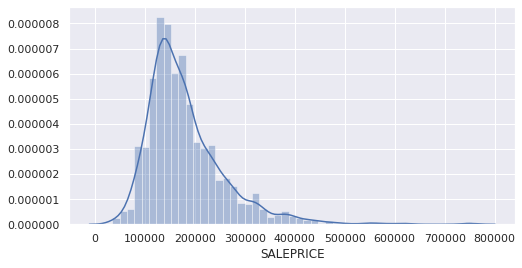

In [6]:
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
ax = sns.distplot(df_pd['SALEPRICE'])
plt.show()

In [7]:

print("The dataset contains columns of the following data types : \n" +str(df_pd.dtypes))


The dataset contains columns of the following data types : 
ID               int64
LOTAREA          int64
BLDGTYPE        object
HOUSESTYLE      object
OVERALLCOND      int64
YEARBUILT        int64
ROOFSTYLE       object
EXTERCOND       object
FOUNDATION      object
BSMTCOND        object
HEATING         object
HEATINGQC       object
CENTRALAIR      object
ELECTRICAL      object
FULLBATH         int64
HALFBATH         int64
BEDROOMABVGR     int64
KITCHENABVGR     int64
KITCHENQUAL     object
TOTRMSABVGRD     int64
FIREPLACES       int64
FIREPLACEQU     object
GARAGETYPE      object
GARAGEFINISH    object
GARAGECARS       int64
GARAGECOND      object
POOLAREA         int64
POOLQC          object
FENCE           object
MOSOLD           int64
YRSOLD           int64
SALEPRICE        int64
dtype: object


Notice below that FIREPLACEQU, GARAGETYPE, GARAGEFINISH, GARAGECOND,FENCE and POOLQC have missing values. 

In [8]:
print("The dataset contains following number of records for each of the columns : \n" +str(df_pd.count()))


The dataset contains following number of records for each of the columns : 
ID              1460
LOTAREA         1460
BLDGTYPE        1460
HOUSESTYLE      1460
OVERALLCOND     1460
YEARBUILT       1460
ROOFSTYLE       1460
EXTERCOND       1460
FOUNDATION      1460
BSMTCOND        1423
HEATING         1460
HEATINGQC       1460
CENTRALAIR      1460
ELECTRICAL      1459
FULLBATH        1460
HALFBATH        1460
BEDROOMABVGR    1460
KITCHENABVGR    1460
KITCHENQUAL     1460
TOTRMSABVGRD    1460
FIREPLACES      1460
FIREPLACEQU      770
GARAGETYPE      1379
GARAGEFINISH    1379
GARAGECARS      1460
GARAGECOND      1379
POOLAREA        1460
POOLQC             7
FENCE            281
MOSOLD          1460
YRSOLD          1460
SALEPRICE       1460
dtype: int64


In [9]:
df_pd.isnull().any()


ID              False
LOTAREA         False
BLDGTYPE        False
HOUSESTYLE      False
OVERALLCOND     False
YEARBUILT       False
ROOFSTYLE       False
EXTERCOND       False
FOUNDATION      False
BSMTCOND         True
HEATING         False
HEATINGQC       False
CENTRALAIR      False
ELECTRICAL       True
FULLBATH        False
HALFBATH        False
BEDROOMABVGR    False
KITCHENABVGR    False
KITCHENQUAL     False
TOTRMSABVGRD    False
FIREPLACES      False
FIREPLACEQU      True
GARAGETYPE       True
GARAGEFINISH     True
GARAGECARS      False
GARAGECOND       True
POOLAREA        False
POOLQC           True
FENCE            True
MOSOLD          False
YRSOLD          False
SALEPRICE       False
dtype: bool

<a id="prepare_data"></a>
## 4. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes bulk of data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices are encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.


In [10]:

#remove columns that are not required
df_pd = df_pd.drop(['ID'], axis=1)

df_pd.head()


,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,HEATING,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
0,8450,1Fam,2Story,5,2003,Gable,TA,PConc,TA,GasA,...,Attchd,RFn,2,TA,0,NaN,NaN,2,2008,208500
1,9600,1Fam,1Story,8,1976,Gable,TA,CBlock,TA,GasA,...,Attchd,RFn,2,TA,0,NaN,NaN,5,2007,181500
2,11250,1Fam,2Story,5,2001,Gable,TA,PConc,TA,GasA,...,Attchd,RFn,2,TA,0,NaN,NaN,9,2008,223500
3,9550,1Fam,2Story,5,1915,Gable,TA,BrkTil,Gd,GasA,...,Detchd,Unf,3,TA,0,NaN,NaN,2,2006,140000
4,14260,1Fam,2Story,5,2000,Gable,TA,PConc,TA,GasA,...,Attchd,RFn,3,TA,0,NaN,NaN,12,2008,250000


In [11]:
# Defining the categorical columns 
categoricalColumns = df_pd.select_dtypes(include=[np.object]).columns

print("Categorical columns : " )
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")
onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute',impute_categorical),('onehot',onehot_categorical)])

Categorical columns : 
Index(['BLDGTYPE', 'HOUSESTYLE', 'ROOFSTYLE', 'EXTERCOND', 'FOUNDATION',
       'BSMTCOND', 'HEATING', 'HEATINGQC', 'CENTRALAIR', 'ELECTRICAL',
       'KITCHENQUAL', 'FIREPLACEQU', 'GARAGETYPE', 'GARAGEFINISH',
       'GARAGECOND', 'POOLQC', 'FENCE'],
      dtype='object')


In [12]:
# Defining the numerical columns 
numericalColumns = [col for col in df_pd.select_dtypes(include=[np.float,np.int]).columns if col not in ['SALEPRICE']]
print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])


Numerical columns : 
['LOTAREA', 'OVERALLCOND', 'YEARBUILT', 'FULLBATH', 'HALFBATH', 'BEDROOMABVGR', 'KITCHENABVGR', 'TOTRMSABVGRD', 'FIREPLACES', 'GARAGECARS', 'POOLAREA', 'MOSOLD', 'YRSOLD']


In [13]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)],
                                            remainder="passthrough")
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")


#. The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_pd)
print("Data after transforming :")
print(df_pd_temp)

df_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_pd)
print("Data after transforming :")
print(df_pd_temp_2)

Data after transforming :
[[1.00000e+00 0.00000e+00 0.00000e+00 ... 2.00000e+00 2.00800e+03
  2.08500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 5.00000e+00 2.00700e+03
  1.81500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 9.00000e+00 2.00800e+03
  2.23500e+05]
 ...
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 5.00000e+00 2.01000e+03
  2.66500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 4.00000e+00 2.01000e+03
  1.42125e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 6.00000e+00 2.00800e+03
  1.47500e+05]]
Data after transforming :
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.59911110e+00
   1.38777489e-01  2.08500000e+05]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.89110051e-01
  -6.14438622e-01  1.81500000e+05]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.90891347e-01
   1.38777489e-01  2.23500000e+05]
 ...
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.89110051e-01
   1.64520971e+00  2.66500000e+05]
 [ 1.00000000e+00  0.00000000e+

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
# prepare data frame for splitting data into train and test datasets

features = []
features = df_pd.drop(['SALEPRICE'], axis=1)

label = pd.DataFrame(df_pd, columns = ['SALEPRICE']) 
#label_encoder = LabelEncoder()
label = df_pd['SALEPRICE']

#label = label_encoder.fit_transform(label)
print(" value of label : " + str(label))




 value of label : 0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SALEPRICE, Length: 1460, dtype: int64


<a id="model_slr"></a>
## 5. Simple linear regression
[Top](#top)

This is the most basic form of linear regression in which the variable to be predicted is dependent on only one other variable. This is calculated by using the formula that is generally used in calculating the slope of a line.

y = w0 + w1*x1

In the above equation, y refers to the target variable and x1 refers to the independent variable. w1 refers to the coeeficient that expresses the relationship between y and x1 it is a.k.a the slope. w0 is the constant cooefficient a.k.a the intercept. It refers to the constant offset that y will always be with respect to the independent variables.

Since simple linear regression assumes that output depends on only one variable, we are assuming that it depends on the YEARBUILT. Data is split up into training and test sets. 

In [15]:
X = features['YEARBUILT'].values.reshape(-1,1)
X_train_slr, X_test_slr, y_train_slr, y_test_slr = train_test_split(X,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train_slr.shape)+ 
      " Output label" + str(y_train_slr.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test_slr.shape)+ 
      " Output label" + str(y_test_slr.shape))

Dimensions of datasets that will be used for training : Input features(1095, 1) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 1) Output label(365,)


In [16]:
from sklearn.linear_model import LinearRegression

model_name = 'Simple Linear Regression'

slRegressor = LinearRegression()

slRegressor.fit(X_train_slr,y_train_slr)

y_pred_slr= slRegressor.predict(X_test_slr)

print(slRegressor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [17]:
print('Intercept: \n',slRegressor.intercept_)
print('Coefficients: \n', slRegressor.coef_)

Intercept: 
 -2517567.321538133
Coefficients: 
 [1368.99630631]


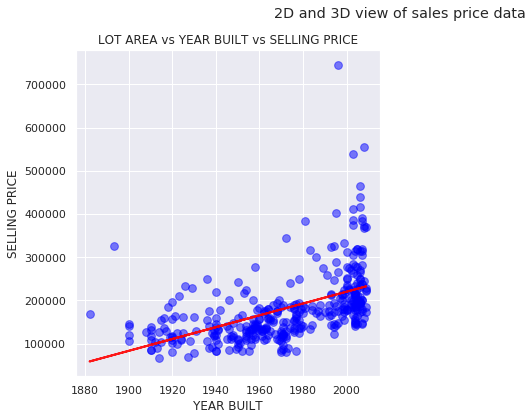

In [18]:
two_vs_three(X_test_slr[:,0],y_test_slr,y_pred_slr,None, True)  

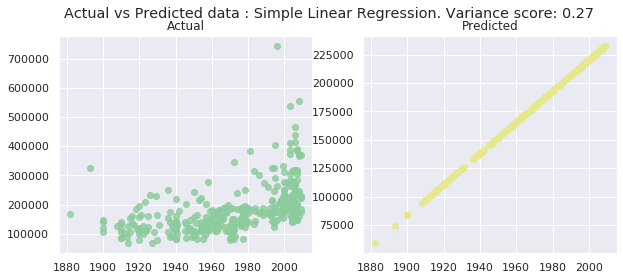

In [19]:
two_d_compare(X_test_slr,y_test_slr,y_pred_slr,model_name)

In [20]:
slrMetrics = model_metrics(slRegressor,y_test_slr,y_pred_slr)

Mean squared error: 4830018416.25
R2 score: 0.27


<a id="model_lrc"></a>
## 6. Build multiple linear regression model
[Top](#top)

Multiple linear regression is an extension to the simple linear regression. In this setup, the target value is dependant on more than one variable. The number of variables depends on the use case at hand. Usually a subject matter expert is involved in identifying the fields that will contribute towards better predicting the output feature.

y = w0 + w1*x1 + w2*x2 + .... + wn*xn

Since multiple linear regression assumes that output depends on more than one variable, we are assuming that it depends on all the 30 features. Data is split up into training and test sets. As an experiment, you can try to remove a few features and check if the model performs any better. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1095, 30) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 30) Output label(365,)


In [22]:
from sklearn.linear_model import LinearRegression

model_name = 'Multiple Linear Regression'

mlRegressor = LinearRegression()

mlr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', mlRegressor)])

mlr_model.fit(X_train,y_train)

y_pred_mlr= mlr_model.predict(X_test)

print(mlRegressor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [23]:
print('Intercept: \n',mlRegressor.intercept_)
print('Coefficients: \n', mlRegressor.coef_)

Intercept: 
 9413823753680914.0
Coefficients: 
 [ 9.11275066e+12  9.11275065e+12  9.11275066e+12  9.11275064e+12
  9.11275065e+12 -2.57212793e+15 -2.57212793e+15 -2.57212793e+15
 -2.57212793e+15 -2.57212793e+15 -2.57212793e+15 -2.57212793e+15
 -2.57212793e+15  3.04170049e+15  3.04170049e+15  3.04170049e+15
  3.04170049e+15  3.04170049e+15  3.04170049e+15 -2.21961931e+15
 -2.21961931e+15 -2.21961931e+15 -2.21961931e+15 -2.21961931e+15
 -4.47750104e+15 -4.47750104e+15 -4.47750104e+15 -4.47750104e+15
 -4.47750104e+15 -4.47750104e+15 -1.29703334e+15 -1.29703334e+15
 -1.29703334e+15 -1.29703334e+15 -1.78615834e+14 -1.78615834e+14
 -1.78615834e+14 -1.78615834e+14 -1.78615834e+14 -1.78615834e+14
  1.99639910e+15  1.99639910e+15  1.99639910e+15  1.99639910e+15
  1.99639910e+15 -1.73664598e+15 -1.73664598e+15  1.10036912e+15
  1.10036912e+15  1.10036912e+15  1.10036912e+15  1.10036912e+15
 -3.87884891e+15 -3.87884891e+15 -3.87884891e+15 -3.87884891e+15
  1.64569076e+15  1.64569076e+15  1.645690

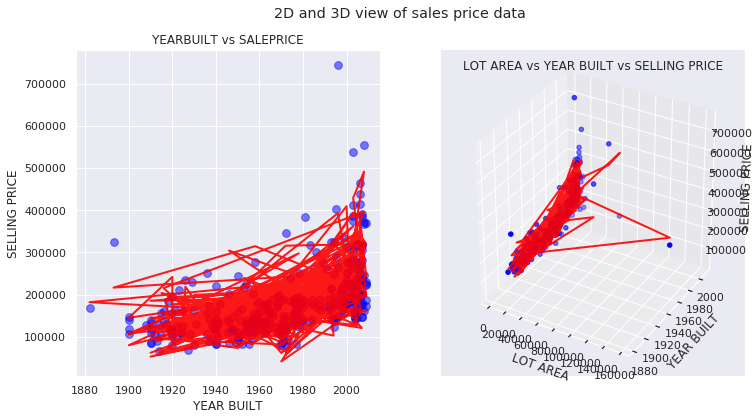

In [24]:
two_vs_three(X_test['YEARBUILT'],y_test,y_pred_mlr,X_test['LOTAREA'], False)  

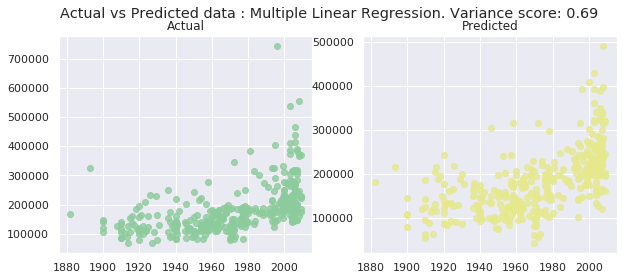

In [25]:
two_d_compare(X_test['YEARBUILT'],y_test,y_pred_mlr,model_name)

In [26]:
mlrMetrics = model_metrics(slRegressor,y_test,y_pred_mlr)

Mean squared error: 2041084937.79
R2 score: 0.69


<a id="model_plr"></a>
## 7. Build Polynomial Linear regression model
[Top](#top)

The prediction line generated by simple/linear regression is usually a straight line. In cases when a simple or multiple linear regression does not fit the data point accurately, we use the polynomial linear regression. The following formula is used in the back-end to generate polynomial linear regression.

y = w0 + w1*x1 + w2*x21 + .... + wn*xnn

We are assuming that output depends on the YEARBUILT and LOTATREA. Data is split up into training and test sets. 

In [27]:
X = features.iloc[:, [0,4]].values
X_train, X_test, y_train, y_test = train_test_split(X,label, random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1095, 2) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 2) Output label(365,)


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

model_name = 'Polynomial Linear Regression'

polynomial_features= PolynomialFeatures(degree=3)
plRegressor = LinearRegression()

plr_model = Pipeline(steps=[('polyFeature',polynomial_features ),('regressor', plRegressor)])

plr_model.fit(X_train,y_train)

y_pred_plr= plr_model.predict(X_test)

print(plRegressor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [29]:
print('Intercept: \n',plRegressor.intercept_)
print('Coefficients: \n', plRegressor.coef_)

Intercept: 
 7962320.595294078
Coefficients: 
 [ 0.00000000e+00  5.86665021e+03 -2.86500328e-01  1.21995572e-03
 -6.03747340e+00 -6.54540867e+00  2.53568011e-10 -6.61206772e-07
  1.55487111e-03  2.29375326e-03]


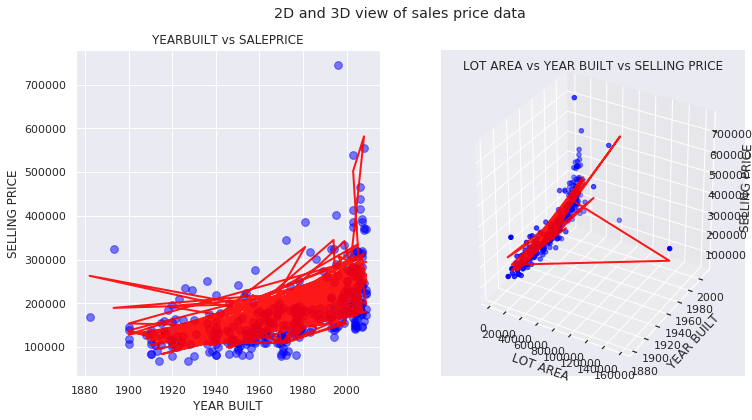

In [30]:
two_vs_three(X_test[:,1],y_test,y_pred_plr,X_test[:,0], False)  

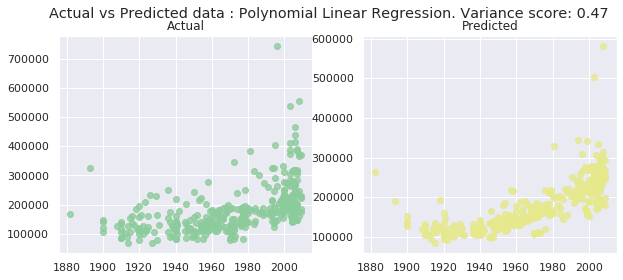

In [31]:
two_d_compare(X_test[:,1],y_test,y_pred_plr,model_name)

In [32]:
plrMetrics = model_metrics(plRegressor,y_test,y_pred_plr)

Mean squared error: 3514933512.95
R2 score: 0.47


<a id="model_dtr"></a>
## 8. Build decision tree regressor
[Top](#top)

In [33]:

X_train, X_test, y_train, y_test = train_test_split(features,df_pd['SALEPRICE'] , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1095, 30) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 30) Output label(365,)


In [34]:
from sklearn.tree import DecisionTreeRegressor

model_name = "Decision Tree Regressor"

decisionTreeRegressor = DecisionTreeRegressor(random_state=0,max_features=30)

dtr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', decisionTreeRegressor)]) 

dtr_model.fit(X_train,y_train)

y_pred_dtr = dtr_model.predict(X_test)

print(decisionTreeRegressor)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=30,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [35]:
export_graphviz(decisionTreeRegressor, out_file ='tree.dot')  
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

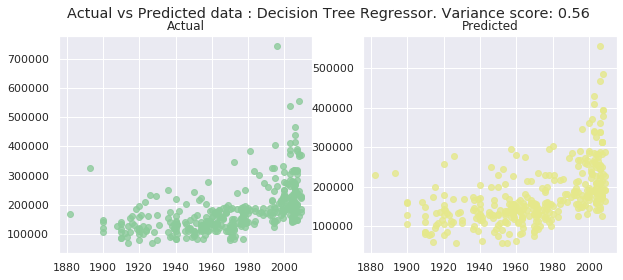

In [36]:
two_d_compare(X_test['YEARBUILT'],y_test,y_pred_dtr,model_name)

In [37]:
dtrMetrics = model_metrics(decisionTreeRegressor,y_test,y_pred_dtr)

Mean squared error: 2912093284.03
R2 score: 0.56


<a id="model_rfr"></a>
## 9. Build Random Forest classification model
[Top](#top)

Decision tree algorithms are efficient in eliminating columns that don't add value in predicting the output and in some cases, we are even able to see how a prediction was derived by backtracking the tree. However, this algorithm doesn't perform individually when the trees are huge and are hard to interpret. Such models are oftern referred to as weak models. The model performance is however improvised by taking an average of several such decision trees derived from the subsets of the training data. This approach is called the Random Forest Regression.

In [38]:
from sklearn.ensemble import RandomForestRegressor

model_name = "Random Forest Regressor"

randomForestRegressor = RandomForestRegressor(n_estimators=100, max_depth=15,random_state=0)

rfr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', randomForestRegressor)]) 

rfr_model.fit(X_train,y_train)

y_pred_rfr = rfr_model.predict(X_test)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


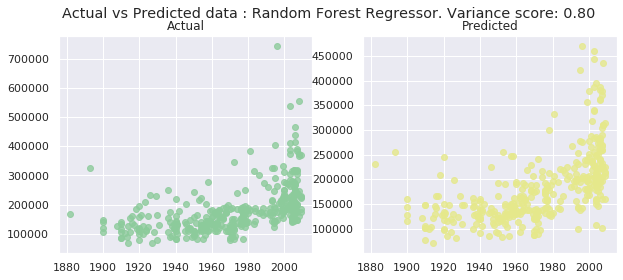

In [39]:
two_d_compare(X_test['YEARBUILT'],y_test,y_pred_rfr,model_name)

In [40]:
rfrMetrics = model_metrics(randomForestRegressor,y_test,y_pred_rfr)

Mean squared error: 1320832739.58
R2 score: 0.80



<a id="compare_classification"></a>
## 10. Comparative study of different regression algorithms. 
[Top](#top)

In the bar chart below, we have compared the performances of different regression algorithms with each other. 
 

In [ ]:

n_groups = 1
index = np.arange(n_groups)
bar_width = 1
opacity = 0.8


area = 60 
plt.subplots(ncols=2, figsize=(12,9))
plt.suptitle('Model performance comparison')

plt.subplot(121)
index = np.arange(n_groups)
bar_width = 1
opacity = 0.8

rects1 = plt.bar(index, slrMetrics[0], bar_width,
alpha=opacity,
color='g',
label='Simple Linear Regression')

rects2 = plt.bar(index + bar_width, mlrMetrics[0], bar_width,
alpha=opacity,
color='pink',
label='Multiple Linear Regression')

rects3 = plt.bar(index + bar_width*2, plrMetrics[0], bar_width,
alpha=opacity,
color='y',
label='Polynomial Linear Regression')

rects4 = plt.bar(index + bar_width*3, dtrMetrics[0], bar_width,
alpha=opacity,
color='b',
label='Decision Tree Regression')


rects6 = plt.bar(index + bar_width*4, rfrMetrics[0], bar_width,
alpha=opacity,
color='purple',
label='Random Forest Regression')

plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Mean Square Error comparison.')
#ax.set_xticklabels(('', 'Simple Lin', 'Multiple Lin', 'Polynomial Lin', 'Decision Tree','Random Forest'))

plt.subplot(122)

rects1 = plt.bar(index, slrMetrics[1], bar_width,
alpha=opacity,
color='g',
label='Simple Linear Regression')

rects2 = plt.bar(index + bar_width, mlrMetrics[1], bar_width,
alpha=opacity,
color='pink',
label='Multiple Linear Regression')

rects3 = plt.bar(index + bar_width*2, plrMetrics[1], bar_width,
alpha=opacity,
color='y',
label='Polynomial Linear Regression')

rects4 = plt.bar(index + bar_width*3, dtrMetrics[1], bar_width,
alpha=opacity,
color='b',
label='Decision Tree Regression')


rects6 = plt.bar(index + bar_width*4, rfrMetrics[1], bar_width,
alpha=opacity,
color='purple',
label='Random Forest Regression')

plt.xlabel('Models')
plt.ylabel('R2')
plt.title('R2 comparison.')
ax.set_xticklabels(('', 'Simple Lin', 'Multiple Lin', 'Polynomial Lin', 'Decision Tree','Random Forest'))



plt.legend()
plt.show()